This python notebook shows how to leverage Spark to load, gas leak, data from Hive and do some k-mean clustering model training based on leak criticality and location. The following steps are detailed in this notebook.

- First we create a Spark dataframe from a Hive/Hadoop data table. From this dataframe we filter the data to create a feature matrix by using only a subset of the information from the data.

- For some historical analytics we can convert the Spark DataFrame to a Panda Data Frame and we plot histograms for the leaks cause and diameter and also plot the data.

- Before we can do any machine learning we first need to convert our feature matrix, currently in a Spark data frame, to a vector matrix.

- Using our feature matrix we can create a location based vector matrix and then run a k mean clustering calcuation on that. We can then save the model back to hadoop to be used later for operationalization and scoring.

- Once we are finished processing the feature matrix we can write the analytics result back to the Hive/Hadoop and visualize the clusters on a geospacial map.

Set the Spark Context

In [1]:
#Set the Spark Context
from pyspark import  SparkContext
from pyspark.sql import SQLContext
sc = SparkContext( 'local', 'pyspark')

Import some libraries and get in a data table from Hive. Constructs a Spark DataFrame(s) from table(s) in Hive using the hive context.

In [2]:
from pyspark.sql import HiveContext
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
from math import sqrt
from numpy import array
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

hiveContext = HiveContext(sc)

# Constructs a DataFrame from the table in Hive.
prod_leak_repair_df = hiveContext.table("prod_leak_repair")

print prod_leak_repair_df.first()

Row(leak_no=3122, repair_no=1, rprd_st_number=None, rprd_st_pfx=u'', rprd_st_name=u'BLUE HILL', rprd_st_sfx=u'AV', rprd_int_st_pfx=u'', rprd_int_st_name=u'INTERVALE', rprd_int_st_sfx=u'ST', rprd_town=u'DOR', rprd_date=u'9/2/1988 00:00:00', pressure=u'L', material=u'CI', diameter=12, main_service=u'M', units_repair=1, where_leak=4, cause=5, repair_code=1, location_comments=u'', main_segment_no=0, street_seg_no=0, stamp_date=u'9/2/1988 00:00:00', entered_by=u'RIV', x_coord=None, y_coord=None, marker=0, link_by=u'', rprd_link_date=u'', rprd_geo_comments=u'DID NOT GEOCODE: BOTH STREETS EXIST BUT DO NOT INTERSECT', objectid=312201, ext_repair_id=u'', created_by=u'', created_date=u'', modified_by=u'ARCFM', modified_date=u'2/11/2009 14:32:21')


Build up a feature matrix by using only a subset of the information from the data. We could have done this from the start by only loading the data we needed. This would be a best practice. Here we create a Spark Data Frame with the following fields: leak_no, cause, x_coord, y_coord, & diameter.

In [3]:
#Build up a feature matrix
feature_matrix = prod_leak_repair_df.select(prod_leak_repair_df.leak_no, prod_leak_repair_df.cause, prod_leak_repair_df.x_coord, prod_leak_repair_df.y_coord, prod_leak_repair_df.diameter,)
#select prod_leak_repair_df,pressure,material,diameter,cause,repair_code,main_segment_no from prod_leak_repair'

print feature_matrix

DataFrame[leak_no: bigint, cause: bigint, x_coord: double, y_coord: double, diameter: bigint]


In [4]:
feature_matrix.count()

332333L

For some historical analytics we can convert the Spark DataFrame to a Panda Data Frame and we plot histograms for the leaks cause and diameter.

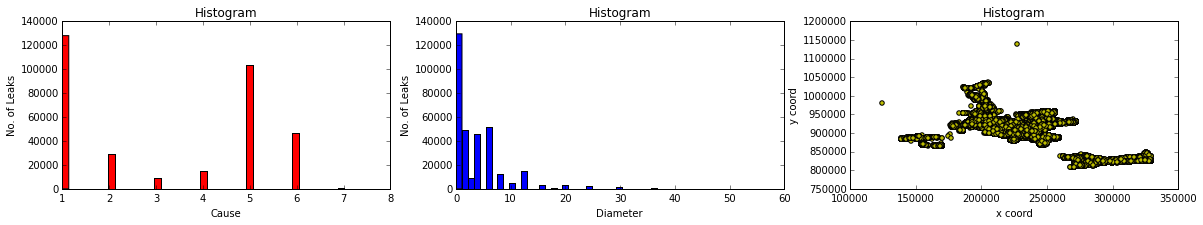

In [5]:
# Convert Spark DataFrame to Pandas
pandas_df = feature_matrix.toPandas()

x = pandas_df.cause
y = pandas_df.diameter 
fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(x, 50, facecolor='r')
axes[0].set_xlabel('Cause')
axes[0].set_ylabel('No. of Leaks')
axes[0].set_title('Histogram');

axes[1].hist(y.dropna(), 50, facecolor='b')
axes[1].set_xlabel('Diameter')
axes[1].set_ylabel('No. of Leaks')
axes[1].set_title('Histogram');

axes[2].scatter(pandas_df.x_coord, pandas_df.y_coord, facecolor='y')
axes[2].set_xlabel('x coord')
axes[2].set_ylabel('y coord')
axes[2].set_title('Histogram');

Before we can do any machine learning we first need to convert our feature matrix, currently in a Spark data frame to a vector matrix.

In [6]:
feature_matrix_vectors = feature_matrix.map(lambda x: Vectors.dense(x)).cache()
feature_matrix_vectors.count()
feature_matrix_vectors.first()

DenseVector([3122.0, 5.0, nan, nan, 12.0])

Using the vector matrix we use Spark's Ml-Lib package to do some simple statistics calcuations

In [7]:
summary = Statistics.colStats(feature_matrix_vectors)
print feature_matrix_vectors.mean()
print feature_matrix_vectors.variance()

[nan,3.24574147015,nan,nan,nan]
[nan,4.18615300201,nan,nan,nan]


In [8]:
cause = feature_matrix.select(feature_matrix.cause)

causeVector = cause.map(lambda x: Vectors.dense(x)).cache()
print cause

DataFrame[cause: bigint]


Using our feature matrix we can create a smaller location based vector matrix and then run a k mean clustering calcuation on that. To determine the number of clusters, just try some values until you visually find meaningful grouping or you have a lower cost value.

The model object exhibits the following methods:

    clusterCenters: returns the centers of each cluster
    cost: returns the cost (sum of square distance of each tweets from its cluster center). The lower it is, the better.
    predict(Vector): return the cluster id closest to the vector point


In [9]:
locations = feature_matrix.select(feature_matrix.x_coord, feature_matrix.y_coord)
locationsVector = feature_matrix.map(lambda feature_matrix: Vectors.dense(array([feature_matrix.x_coord if feature_matrix.x_coord is not None else 0, feature_matrix.y_coord if feature_matrix.y_coord is not None else 0]))).cache()
print locationsVector.first()

[0.0,0.0]


In [46]:

# Build the model (cluster the data)
clusters = KMeans.train(locationsVector, 5, maxIterations=10,runs=10, initializationMode="random")
print clusters.clusterCenters
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = locationsVector.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

#Maps given points to their cluster indices.

clusterPred = locationsVector.map(lambda x: clusters.predict(x))
clusterMap = locationsVector.zip(clusterPred)

[array([ 246028.2610749,  925308.859907 ]), array([ 203109.72911005,  935389.39510132]), array([ 233283.89424743,  899117.79498347]), array([ 295037.19777074,  824330.34491322]), array([ 0.,  0.])]
Within Set Sum of Squared Error = 4255309845.25


Plot the clusters and ignore the 0,0 cluster

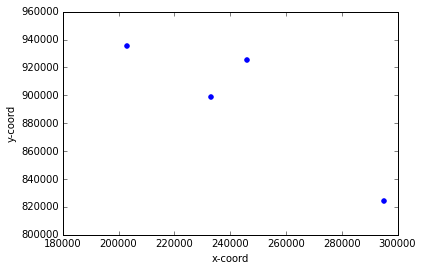

In [47]:

clusters.clusterCenters.pop() 

plt.scatter([item[0] for item in clusters.clusterCenters],[item[1] for item in clusters.clusterCenters],color='b')
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.show()

Once we are finished processing the feature matrix we can write the analytics result back to the Hive/Hadoop and use the as a statement of record for the analytics. 

To do this we first need to converte the vector matrix back into a Spark Data Frame. For this we need to provide it with a schema.

In [30]:
# Convert back to the orginal DF schema - DataFrame[leak_no: bigint, cause: bigint, x_coord: double, y_coord: double, diameter: bigint]
feature_matrix_with_schema = feature_matrix_vectors.map(lambda v: {"leak_no": int(v[0].astype(int)), "cause": int(v[1].astype(int)), "diameter": int(v[4].astype(int))})

feature_matrix_with_schema.first()

{'cause': 5, 'diameter': 12, 'leak_no': 3122}

In [31]:
data_frame_table = hiveContext.createDataFrame(feature_matrix_with_schema)
#data_frame_table.saveAsTable("leak_feature_matrix_with_schema2")
print data_frame_table
data_frame_table.count()
data_frame_table.printSchema()

DataFrame[cause: bigint, diameter: bigint, leak_no: bigint]
root
 |-- cause: long (nullable = true)
 |-- diameter: long (nullable = true)
 |-- leak_no: long (nullable = true)



/usr/hdp/current/spark-client/python/pyspark/sql/context.py:169: UserWarning: Using RDD of dict to inferSchema is deprecated,please use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated,"


In [34]:
data_frame_table.registerTempTable("leak_hive3") 
hiveContext.sql('create table leak_hive3 as select cause, diameter, leak_no from leak_hive2')

DataFrame[]